In [1]:
from SimPEG import maps, data
import numpy as np
from discretize import TensorMesh
from matplotlib.colors import LogNorm
from simpegEM1D.simulation_stitched1d_original import (
    GlobalEM1DSimulationFD, GlobalEM1DSurveyFD
)
from simpegEM1D.EM1DSimulation_original import get_vertical_discretization_frequency
from pymatsolver import PardisoSolver
from simpegEM1D.EM1DSimulation_original import *
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import empymod

# Seting up a 2D mesh and model

In [3]:
frequency = np.array([25., 100., 382, 1822, 7970, 35920], dtype=float)
hz = get_vertical_discretization_frequency(frequency, sigma_background=0.1, n_layer=30)

In [4]:
from scipy.spatial import Delaunay
def PolygonInd(mesh, pts):
    hull = Delaunay(pts)
    inds = hull.find_simplex(mesh.gridCC)>=0
    return inds

In [5]:
n_sounding = 50
dx = 100.
hx = np.ones(n_sounding) * dx
mesh = TensorMesh([hx, hz], x0='00')
inds =  mesh.gridCC[:,1]<25
sigma = np.ones(mesh.nC) * 1./20.
sigma[inds] = 1./30.
x0 = np.r_[0., 75.]
x1 = np.r_[dx*n_sounding, 75.]
x2 = np.r_[dx*n_sounding, 90.]
x3 = np.r_[0., 200.]
pts = np.vstack((x0, x1, x2, x3, x0))
poly_inds = PolygonInd(mesh, pts)
sigma[poly_inds] = 1./50
sigma_em1d = sigma.reshape(mesh.vnC, order='F').flatten()
chi = np.zeros_like(sigma_em1d)
# chi[poly_inds] = 0.005

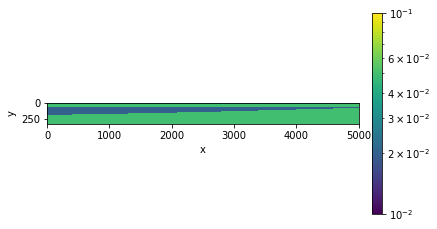

In [6]:
cb = plt.colorbar(
    mesh.plotImage(sigma, grid=False, clim=(1e-2, 1e-1),pcolorOpts={"norm":LogNorm()})[0],
    fraction=0.03, pad=0.04
)

plt.ylim(mesh.vectorNy.max(), mesh.vectorNy.min())
plt.gca().set_aspect(1)

In [7]:
x = mesh.vectorCCx
y = np.zeros_like(x)
z = np.ones_like(x) * 30.
rx_locations = np.c_[x, y, z]
src_locations = np.c_[x, y, z]
topo = np.c_[x, y, z-30.].astype(float)

In [8]:
mapping = maps.ExpMap(mesh)
# mapping = Maps.IdentityMap(mesh)
survey = GlobalEM1DSurveyFD(
    rx_locations = rx_locations,
    src_locations = src_locations,    
    frequency = frequency,
    offset = np.ones_like(frequency) * 7.86,
    src_type = "VMD",
    rx_type = "ppm",
    field_type = 'secondary',
    topo = topo
)
sim = GlobalEM1DSimulationFD(
    mesh, survey=survey, sigmaMap=mapping, chi=chi, hz=hz, parallel=True, n_cpu=2, verbose=True,
    Solver=PardisoSolver
)

m = np.log(sigma_em1d)
# m =  sigma_em1d.copy()

>> Use multiprocessing for parallelization
>> n_cpu: 2


In [9]:
# %%time
# dobs = sim.makeSyntheticData(m, std=0.03, force=True)
d_true = sim.dpred(m)
std = 0.03
floor = 0.
np.random.seed(1)
uncert = std*abs(d_true)+floor
noise = std*np.abs(d_true)*np.random.randn(len(d_true))
d_obs = d_true + noise


Compute fields
>> Compute response


In [10]:
m0 = np.ones(mesh.nC) * np.log(1./20.)
mapping = maps.ExpMap(mesh)
sim.sigmaMap = mapping
sim._Jmatrix_sigma = [
    run_simulation_FD(sim.input_args(i, jac_switch='sensitivity_sigma')) for i in range(sim.n_sounding)
]
print("J_sigma matrix shape")
sim._Jmatrix_sigma = np.hstack(sim._Jmatrix_sigma)
print(sim._Jmatrix_sigma.shape)
print("IJLayers shapes")
for x in sim.IJLayers:
    print(x.shape)

J_sigma matrix shape
(18000,)
IJLayers shapes
(18000,)
(18000,)


In [11]:
J = sim.getJ_sigma(m0)

Text(0, 0.5, 'Hz/Hp (ppm)')

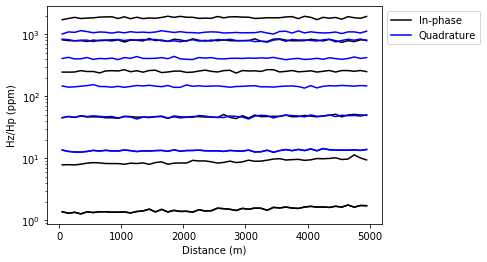

In [12]:
DOBS = d_obs.reshape(( sim.n_sounding, 2, survey.n_frequency))
i_freq=0
plt.semilogy(mesh.vectorCCx, DOBS[:,0,i_freq], 'k')
plt.semilogy(mesh.vectorCCx, DOBS[:,1,i_freq], 'b')    
plt.legend(("In-phase", "Quadrature"), bbox_to_anchor=(1,1))
for i_freq in range(survey.n_frequency):
    plt.semilogy(mesh.vectorCCx, DOBS[:,0,i_freq], 'k')
for i_freq in range(survey.n_frequency):
    plt.semilogy(mesh.vectorCCx, DOBS[:,1,i_freq], 'b')    
plt.xlabel("Distance (m)")
plt.ylabel("Hz/Hp (ppm)")

In [13]:
from SimPEG import (
    regularization, directives, inversion, inverse_problem, optimization, data_misfit, utils
)
from simpegEM1D import get_2d_mesh, LateralConstraint

In [14]:
def run_inversion(option=None, ps=2, px=2, pz=2, alpha_s=1., alpha_x=1., alpha_z=1.):
    
    mapping = maps.ExpMap(mesh)
    # mapping = Maps.IdentityMap(mesh)
    survey = GlobalEM1DSurveyFD(
        rx_locations = rx_locations,
        src_locations = src_locations,    
        frequency = frequency,
        offset = np.ones_like(frequency) * 7.86,
        src_type = "VMD",
        rx_type = "ppm",
        field_type = 'secondary',
        topo = topo
    )

    sim = GlobalEM1DSimulationFD(
        mesh, survey=survey, sigmaMap=mapping, chi=chi, hz=hz, parallel=True, n_cpu=2, verbose=True,
        Solver=PardisoSolver
    )

#     m = np.log(sigma_em1d)

    std = 0.03
    floor = 0.
    np.random.seed(1)
    uncert = std*abs(d_obs)+floor
    dataObj = data.Data(survey, dobs=d_obs, noise_floor=uncert)
    
    mesh_reg = get_2d_mesh(n_sounding, hz)
    regmap = maps.IdentityMap(mesh_reg)
    # mapping is required ... for IRLS
    reg = LateralConstraint(
        mesh_reg, mapping=regmap,
        alpha_s = alpha_s,
        alpha_x = alpha_x,
        alpha_y = alpha_z,
    )
    xy = utils.ndgrid(np.arange(n_sounding), np.r_[0.])
    reg.get_grad_horizontal(xy, hz, dim=2, use_cell_weights=True)
    
    
    m0 = np.ones(mesh_reg.nC) * np.log(1./20.)
#     m0 = np.ones(mesh_reg.nC) *1./20.
    dmisfit = data_misfit.L2DataMisfit(dataObj, sim)
    dmisfit.W = 1./uncert
    ps = ps
    px, pz = px, pz
    reg.norms = np.c_[ps, px, pz, 0.]
    IRLS = directives.Update_IRLS(
        max_irls_iterations=30, minGNiter=1, 
        fix_Jmatrix=True, 
        f_min_change = 1e-4,
        coolingRate=3
    )
    opt = optimization.InexactGaussNewton(maxIter = 40, maxIterCG=20)
    
    invProb = inverse_problem.BaseInvProblem(dmisfit, reg, opt)
    
    beta = directives.BetaSchedule(coolingFactor=2, coolingRate=1)
    sense = directives.UpdateSensitivityWeights()
    betaest = directives.BetaEstimate_ByEig(beta0_ratio=1.)
    target = directives.TargetMisfit()
    update_precon = directives.UpdatePreconditioner()
    if option is None:
        reg.alpha_x=0.
        inv = inversion.BaseInversion(invProb, directiveList=[beta,sense,betaest,target])        
    elif option == "l2":
        reg.alpha_x=10.        
        inv = inversion.BaseInversion(invProb, directiveList=[beta, sense, betaest, target])
    elif option == "l0":
        inv = inversion.BaseInversion(invProb, directiveList=[IRLS, sense, betaest])
#     prob.counter = opt.counter = Utils.Counter()
    opt.LSshorten = 0.5
    opt.remember('xc')
#     print (reg.cell_weights)
    mopt = inv.run(m0) 
    if option == 'l0':
        return mopt, invProb.l2model, invProb.dpred
    else:
        return mopt, None, invProb.dpred

In [15]:
# mopt_none, pred = run_inversion(option=None)

In [16]:
# mopt_l2, pred = run_inversion(option='l2')

In [17]:
mopt_l0_ps0, mopt_l2_ps0, pred = run_inversion(option='l2', ps=0, px=2, pz=2, alpha_s=1., alpha_x=10., alpha_z=1.)

>> Use multiprocessing for parallelization
>> n_cpu: 2
SimPEG.InvProblem will set Regularization.mref to m0.

        SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
        ***Done using same Solver and solverOpts as the problem***
>> Compute J sigma
Compute fields
>> Compute response
model has any nan: 0
============================ Inexact Gauss Newton ============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  3.43e+02  2.50e+04  0.00e+00  2.50e+04    6.16e+03      0              
Compute fields
>> Compute response
>> Compute J sigma
   1  1.71e+02  3.02e+03  1.02e+01  4.77e+03    1.01e+03      0              
Compute fields
>> Compute response
>> Compute J sigma
   2  8.57e+01  9.78e+02  1.59e+01  2.34e+03    3.72e+02      0   Skip BFGS  
Compute fields
>> Compute response
>> Compute J sigma
   3  4.29e+01  5.26e

In [18]:
mopt_l0_qx2, mopt_l2_qx2, pred = run_inversion(option='l0', ps=2, px=2, pz=0, alpha_s=1e-2, alpha_x=10., alpha_z=1.)

>> Use multiprocessing for parallelization
>> n_cpu: 2
SimPEG.InvProblem will set Regularization.mref to m0.

        SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
        ***Done using same Solver and solverOpts as the problem***
>> Compute J sigma


D:\Documents\Repositories\simpeg\SimPEG\directives.py:916: UserWarning: Without a Linear preconditioner, convergence may be slow. Consider adding `Directives.UpdatePreconditioner` to your directives list
  "Without a Linear preconditioner, convergence may be slow. "


Compute fields
>> Compute response
model has any nan: 0
============================ Inexact Gauss Newton ============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  4.98e+02  2.50e+04  0.00e+00  2.50e+04    6.16e+03      0              
Compute fields
>> Compute response
>> Compute J sigma
   1  4.98e+02  1.53e+03  2.52e-01  1.65e+03    7.68e+02      0              
Compute fields
>> Compute response
>> Compute J sigma
   2  4.98e+02  3.87e+02  3.53e-01  5.63e+02    7.87e+01      0   Skip BFGS  
Compute fields
>> Compute response
>> Compute J sigma
   3  2.49e+02  3.42e+02  3.93e-01  4.40e+02    7.40e+01      0   Skip BFGS  
Compute fields
>> Compute response
Reached starting chifact with l2-norm regularization: Start IRLS steps...
eps_p: 0.48452322852378993 eps_q: 0.48452322852378993
>> Fix Jmatrix
>> Compute J sigma
   4  2.49e+02  2.96

In [19]:
mopt_l0, mopt_l2, pred = run_inversion(option='l0', ps=2, px=0, pz=0, alpha_s=1e-2, alpha_x=10., alpha_z=1.)

>> Use multiprocessing for parallelization
>> n_cpu: 2
SimPEG.InvProblem will set Regularization.mref to m0.

        SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
        ***Done using same Solver and solverOpts as the problem***
>> Compute J sigma


D:\Documents\Repositories\simpeg\SimPEG\directives.py:916: UserWarning: Without a Linear preconditioner, convergence may be slow. Consider adding `Directives.UpdatePreconditioner` to your directives list
  "Without a Linear preconditioner, convergence may be slow. "


Compute fields
>> Compute response
model has any nan: 0
============================ Inexact Gauss Newton ============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  4.98e+02  2.50e+04  0.00e+00  2.50e+04    6.16e+03      0              
Compute fields
>> Compute response
>> Compute J sigma
   1  4.98e+02  1.53e+03  2.52e-01  1.65e+03    7.68e+02      0              
Compute fields
>> Compute response
>> Compute J sigma
   2  4.98e+02  3.87e+02  3.53e-01  5.63e+02    7.87e+01      0   Skip BFGS  
Compute fields
>> Compute response
>> Compute J sigma
   3  2.49e+02  3.42e+02  3.93e-01  4.40e+02    7.40e+01      0   Skip BFGS  
Compute fields
>> Compute response
Reached starting chifact with l2-norm regularization: Start IRLS steps...
eps_p: 0.4831159414302415 eps_q: 0.4831159414302415
>> Fix Jmatrix
>> Compute J sigma
   4  2.49e+02  2.96e+

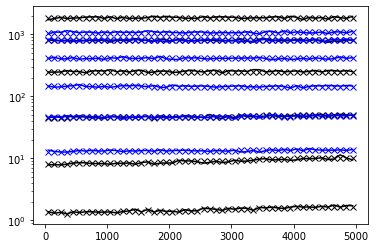

In [20]:
DOBS = d_obs.reshape((sim.n_sounding, 2, survey.n_frequency))
DPRED = pred.reshape((sim.n_sounding, 2, survey.n_frequency))
for i_freq in range(survey.n_frequency):
    plt.semilogy(mesh.vectorCCx, DOBS[:,0,i_freq], 'k')
    plt.semilogy(mesh.vectorCCx, DPRED[:,0,i_freq], 'kx')
for i_freq in range(survey.n_frequency):
    plt.semilogy(mesh.vectorCCx, DOBS[:,1,i_freq], 'b')
    plt.semilogy(mesh.vectorCCx, DPRED[:,1,i_freq], 'bx')

In [21]:
sigma_est_l2 = utils.mkvc((np.exp(mopt_l2)).reshape((sim.n_sounding, sim.n_layer)))
sigma_est_l2_qx2 = utils.mkvc((np.exp(mopt_l2_qx2)).reshape((sim.n_sounding, sim.n_layer)))
# sigma_est_l2_ps0 = utils.mkvc((np.exp(mopt_l2_ps0)).reshape((sim.n_sounding, sim.n_layer)))

sigma_est_l0 = utils.mkvc((np.exp(mopt_l0)).reshape((sim.n_sounding, sim.n_layer)))
sigma_est_l0_qx2 = utils.mkvc((np.exp(mopt_l0_qx2)).reshape((sim.n_sounding, sim.n_layer)))
sigma_est_l0_ps0 = utils.mkvc((np.exp(mopt_l0_ps0)).reshape((sim.n_sounding, sim.n_layer)))

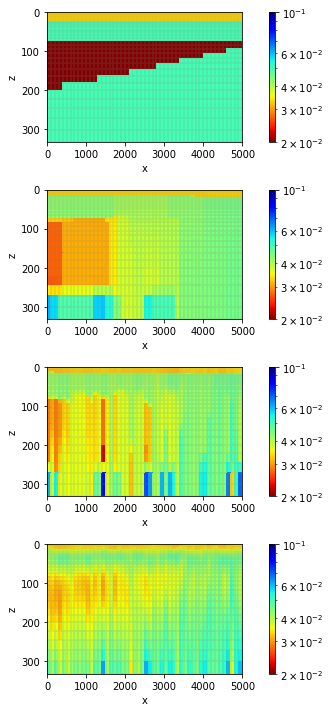

In [22]:
sigmas = [
    sigma, 
    sigma_est_l0,
    sigma_est_l0_qx2,
    sigma_est_l0_ps0
]
fig, axs = plt.subplots(4,1, figsize=(10, 10))
for ii in range(4):
    cb = plt.colorbar(
        mesh.plotImage(
            sigmas[ii], grid=True, clim=(1./50, 1e-1), ax=axs[ii], 
            pcolorOpts={"norm":LogNorm(), 'cmap': 'jet_r'},
            gridOpts={'alpha':0.2, 'color':'grey'}
        )[0],
        fraction=0.02, pad=0.04, ax=axs[ii]
    )
    axs[ii].set_ylim(mesh.vectorNy.max(), mesh.vectorNy.min())
    axs[ii].set_ylabel("z")
    axs[ii].set_ylim(mesh.vectorNy.max(), mesh.vectorNy.min())
    axs[ii].set_aspect(10)
plt.tight_layout()

In [23]:
sigmas = [
    sigma, 
    sigma_est_l2,
    sigma_est_l2_qx2,
    sigma_est_l2_ps0
]
fig, axs = plt.subplots(4,1, figsize=(5, 10))
for ii in range(3):
    cb = plt.colorbar(
        mesh.plotImage(
            sigmas[ii], grid=True, clim=(1./50, 1e-1), ax=axs[ii], 
            pcolorOpts={"norm":LogNorm(), 'cmap': 'jet_r'},
            gridOpts={'alpha':0.2, 'color':'grey'}
        )[0],
        fraction=0.02, pad=0.04, ax=axs[ii]
    )
    axs[ii].set_ylim(mesh.vectorNy.max(), mesh.vectorNy.min())
    axs[ii].set_ylabel("z")
    axs[ii].set_ylim(mesh.vectorNy.max(), mesh.vectorNy.min())
    axs[ii].set_aspect(10)
plt.tight_layout()

NameError: name 'sigma_est_l2_ps0' is not defined